In [53]:
import numpy as np
import time
import matplotlib
import matplotlib.pyplot as plt
import lsst.meas.base
import lsst.pex.config
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom
import lsst.afw.table
import lsst.meas.algorithms
import lsst.meas.deblender
import lsst.pex.exceptions
import lsst.meas.extensions.gaap

from kuaizi.display import display_single
from astropy.io import fits
from astropy.table import Table, QTable, hstack

## Try gaap with reference catalog

In [134]:
# Load Merian catalog as reference
filt = 'N708'
tract = 9813
patch = 23
patch_old = f'{patch % 9},{patch // 9}'

import lsst.daf.butler as dafButler
butler = dafButler.Butler('/projects/MERIAN/repo/')
dataId = dict(tract=tract, patch=patch, band=filt)

refCat = butler.get(
    'deepCoadd_forced_src',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)[:9000]

childs = []
for parent in refCat[:100]['id']:
    childs += list(np.where(refCat['parent'] == parent)[0])
    
temp = refCat[0:1]
for item in refCat[childs[0]:childs[-1]]:
    temp.append(item)
refCat = temp

refExposure = butler.get(
    'deepCoadd_calexp',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)

refCatInBand = butler.get(
    'deepCoadd_ref',
    collections='DECam/runs/merian/dr1_wide',
    dataId=dataId,
    instrument='DECam',
    skymap='hsc_rings_v1',
)[:9000]

temp = refCatInBand[0:1]
for item in refCatInBand[childs[0]:childs[-1]]:
    temp.append(item)
refCatInBand = temp

# refCatInBand = lsst.afw.table.SourceCatalog.readFits(
#     '/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/5,3/deblendedFlux-HSC-G-9813-5,3.fits')

expID = dict(tract=tract, patch=patch, band=filt, skymap='hsc_rings_v1')

In [135]:
len(refCat)

515

In [136]:
hsc_type = 'w40'
if hsc_type == 'w40':
    exposure = lsst.afw.image.ExposureF(
        f'/scratch/arunj/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_40_DM-36356_20221006T193226Z.fits'
    )
elif hsc_type == 'w04':
    exposure = lsst.afw.image.ExposureF(
        f"/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/{patch}/i/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits"
    )
elif hsc_type == 'S20A':
    exposure = lsst.afw.image.ExposureF(
        f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/{patch_old}/calexp-HSC-I-{tract}-{patch_old}.fits"
    )

In [137]:
# exposure = refExposure.clone()

In [138]:
# exposure = lsst.afw.image.ExposureF(
#     f"/projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/{patch_old}/calexp-HSC-I-{tract}-{patch_old}.fits")
# exposure = lsst.afw.image.ExposureF(
#     f'/scratch/arunj/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_40_DM-36356_20221006T193226Z.fits'
# )
# exposure = lsst.afw.image.ExposureF(
#     f"/projects/MERIAN/repo/HSC/runs/RC2/w_2022_04/DM-33402/20220128T212035Z/deepCoadd_calexp/9813/{patch}/i/deepCoadd_calexp_9813_{patch}_i_hsc_rings_v1_HSC_runs_RC2_w_2022_04_DM-33402_20220128T212035Z.fits")
# exposure = lsst.afw.image.ExposureF(
#     "/projects/MERIAN/repo/DECam/runs/merian/dr1_wide/20220921T193246Z/deepCoadd_calexp/9813/79/N708/deepCoadd_calexp_9813_79_N708_hsc_rings_v1_DECam_runs_merian_dr1_wide_20220921T193246Z.fits")

rsync -zva --progress jiaxuanl@tiger.princeton.edu://projects/MERIAN/repo/S20A/deepCoadd_calexp/9813/5,3/calexp-HSC-I-9813-5,3.fits ./

In [139]:
measureConfig = lsst.meas.base.ForcedPhotCoaddConfig()
measureConfig.footprintDatasetName = 'DeblendedFlux'

measureConfig.measurement.plugins.names.add("base_PsfFlux")
measureConfig.measurement.plugins.names.add("base_CircularApertureFlux")
measureConfig.measurement.plugins.names.add("base_SdssShape")
measureConfig.measurement.plugins.names.add("base_SdssCentroid")
measureConfig.measurement.plugins.names.add("ext_gaap_GaapFlux")

measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doMeasure = True  # Set it to False for timing comparison
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doPsfPhotometry = True
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].doOptimalPhotometry = True
measureConfig.measurement.plugins["ext_gaap_GaapFlux"].sigmas = [0.5, 0.75, 1.0, 1.5, 2.0]

photTask = lsst.meas.base.ForcedPhotCoaddTask(refSchema=refCat.schema, config=measureConfig)

In [140]:
measCat, exposureID = photTask.generateMeasCat(exposureDataId=butler.registry.expandDataId(expID), 
                                               exposure=exposure, 
                                               refCat=refCat, 
                                               refCatInBand=refCatInBand, 
                                               refWcs=refExposure.wcs, 
                                               idPackerName='tract_patch', 
                                               footprintData=refCatInBand)

In [141]:
print("# Starting the measureTask at ", time.ctime())
t1 = time.time()
photTask.run(measCat, exposure, refCat=refCat, refWcs=refExposure.wcs, exposureId=exposureID)
t2 = time.time()
print("# Finished measureTask in %.2f seconds." % (t2-t1))
cat2 = measCat.copy(deep=True).asAstropy()

# Starting the measureTask at  Fri Nov 11 19:23:33 2022


RuntimeError: Reference catalog contains a child for which at least one parent in its parent chain is not in the catalog.

In [101]:
def writeObjectTable(measCat, band='i', save=True):
    import astropy.units as u
    from astropy.table import QTable
    
    outCat = measCat.copy(deep=True).asAstropy()
    outCat['coord_ra'] = outCat['coord_ra'].to(u.deg)
    outCat['coord_dec'] = outCat['coord_dec'].to(u.deg)

    old_gaap_cols = [
        item for item in measCat.schema.getNames() if 'gaap' in item and 'apCorr' not in item]
    outCat = outCat[['id', 'coord_ra', 'coord_dec'] + old_gaap_cols]
    
    # PhotCalib
    for col in old_gaap_cols:
        if 'instFlux' in col:
            outCat[col] = outCat[col].value * \
                exposure.getPhotoCalib().instFluxToNanojansky(1) * u.nanomaggy

    new_gaap_cols = []
    for col in old_gaap_cols:
        name = col.replace('ext_gaap_GaapFlux', f'{band}_gaap')
        name = name.replace('_instFlux', 'Flux').replace('PsfFlux', 'Psf')
        if 'Flux' in name:
            aper = name.split(
                "x_")[-1].replace('FluxErr', '').replace('Flux', '')
            name = name.replace('_1_15x', '')
            name = name.replace('_' + aper, aper.replace('_', 'p'))

        if 'flag' in name:
            aper = name.split(
                "x_")[-1].replace('_flag_bigPsf', '').replace('_flag', '')
            name = name.replace('_1_15x', '')
            if not 'gauss' in name:
                name = name.replace(
                    '_' + aper, aper.replace('_', 'p') + 'Flux')
        new_gaap_cols.append(name)
    
    outCat.rename_columns(old_gaap_cols, new_gaap_cols)
    outCat = QTable(outCat)
    return outCat

In [115]:
cat2 = writeObjectTable(measCat, band='i')
cat2.remove_columns(['id', 'coord_ra', 'coord_dec'])
cat_ref = writeObjectTable(refCat, band='N708')

In [116]:
cat = hstack([cat_ref, cat2])

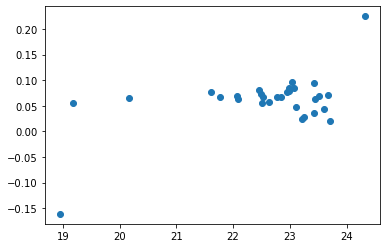

In [142]:
plt.scatter(30 - 2.5 * np.log10(cat['i_gaap1p0Flux'].data), 
            -2.5 * np.log10(cat['i_gaap1p0Flux'] / cat['N708_gaap1p0Flux']))

In [56]:
cat = hstack([cat_ref, cat2])
cat.write('/projects/MERIAN/repo/S20A/gaapTable/9813/gaap_9813_23_Merian_w04_i.fits')

In [49]:
photCalib = exposure.getPhotoCalib()
photCalib.instFluxToNanojansky(1)

57.543993733715425

Text(0, 0.5, 'Delta(i), manual - RC2')

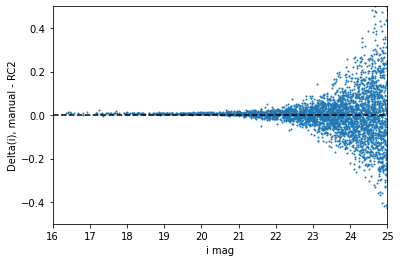

In [12]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

plt.xlim(16, 25)
plt.ylim(-0.5, 0.5)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

Text(0, 0.5, 'Delta(i), manual - RC2')

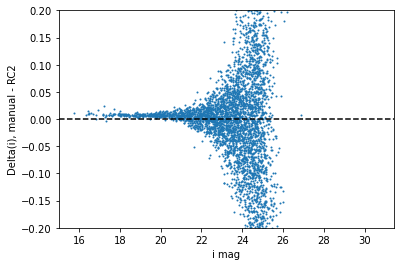

In [9]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

# plt.xlim(20, 29)
plt.ylim(-0.2, 0.2)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

Text(0, 0.5, 'Delta(i), manual - RC2')

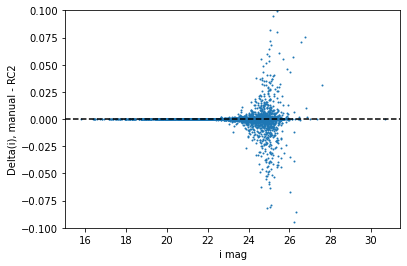

In [25]:
fig, ax = plt.subplots(figsize=(6, 4))

mag = 30 - 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data * 57.543993733715425)
diff = - 2.5 * np.log10(cat2['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data) + 2.5 * np.log10(refCat.asAstropy()['ext_gaap_GaapFlux_1_15x_1_0_instFlux'].data)
plt.scatter(mag, 
            diff,
            s=1)

# plt.xlim(20, 29)
plt.ylim(-0.1, 0.1)

plt.axhline(0, color='k', ls='--')

plt.xlabel('i mag')
plt.ylabel('Delta(i), manual - RC2')

In [7]:
import lsst.afw.display as afwDisplay
import lsst.afw.geom as afwGeom

In [12]:
recordId = 3
shape = refCat[recordId].getShape()
shape

Quadrupole(ixx=25.274688626204505, iyy=21.87229112267094, ixy=-7.246451166126677)

TypeError: %d format: a real number is required, not Figure

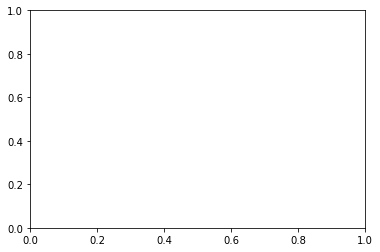

In [14]:
afwDisplay.setDefaultBackend('matplotlib')
fig, ax = plt.subplots()
display = afwDisplay.Display(frame=fig)
display.scale("linear", "zscale")
display.setMaskTransparency(80)

obj = refCatInBand[recordId]
footprint = obj.getFootprint()
bbox = footprint.getBBox()
cutout = exposure[bbox]
display.mtv(cutout)
display.dot(shape, *obj.getCentroid()) #*bbox.getCenter())
# ax[1].set_title(f"recordId = {recordId}")